In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt

from stimuli import generate_sequence, encode_input, Dataset
from snn_params import Params
from snn_network import SNN

In [58]:
plt.rcParams.update({'figure.figsize': (8, 6)})
plt.rcParams.update({'font.size': 14})

In [3]:
# Initialize parameters
params = Params()
params.config_sim(tmin=0, tmax=0.6, dt=0.001)
print(params.sim["T"][0:10])

[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009]


### Input sequence

In [4]:
# Create full dataset
seq, rsp, out_seq = generate_sequence(n_inner=4, n_outer=300, seed=95)
inp = encode_input(sequence=seq)
print(np.sum(out_seq=="AX"))
print(np.sum(out_seq=="BY"))

239
245


1072


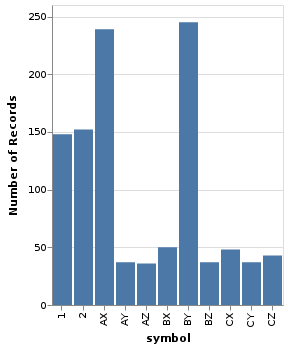

In [5]:
# Create dataframe for viz
df = pd.DataFrame(data=out_seq, columns=["symbol"])
print(len(out_seq))
# contruct a char

alt.Chart(data=df).mark_bar().encode(
    x="symbol",
    y="count()"
).interactive()


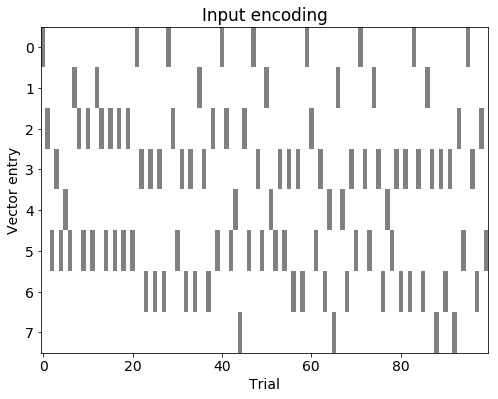

In [59]:
plt.imshow(inp[:, 0:100], aspect="auto", cmap="gray_r", alpha=0.5)
plt.title("Input encoding")
plt.xlabel("Trial")
plt.ylabel("Vector entry")
plt.show()

Create a shorter Pytorch dataset subclass

In [7]:
# Use less trials
seq2, rsp2, out_seq2 = generate_sequence(n_inner=4, n_outer=2, seed=95)
print(seq2)
inp2 = encode_input(sequence=seq2)
print(inp2.shape)
ds2 = Dataset(sequence=seq2, response=rsp2, encoding=inp2)
print(ds2.encoding.shape)

['1' 'A' 'X' 'B' 'X' 'C' 'X' '2' 'A' 'X' 'A' 'X']
(8, 12)
(8, 12)


### Network set up

In [141]:
# Set up the network architecture and define parameters
net = SNN(n_neurons=1000, input_dim=8, output_dim=2)

# Membrane parameters
net.config_membrane(E=-0.07, V_reset=-0.08, V_thr=-0.05, R=1e6, tau=0.01)  # Membrane parameters

# Synaptic parameters
net.config_syn(tau=0.5, delta_g=10e-9)
net.config_input_weights(mean=0.4, density=0.05, seed=1)
net.config_recurrent_weights(density=0.1, ex=0.8, seed=2)
net.weight_scaling(input_scaling=25, recurrent_scaling=1.9e-9)

# Spike-rate adaptation and refractoriness
net.config_gsra(tau=0.4, delta=15e-9, E_r=-0.08)
net.config_gref(tau=0.002, delta=200e-9, E_r=-0.08)

### Connectivity matrices

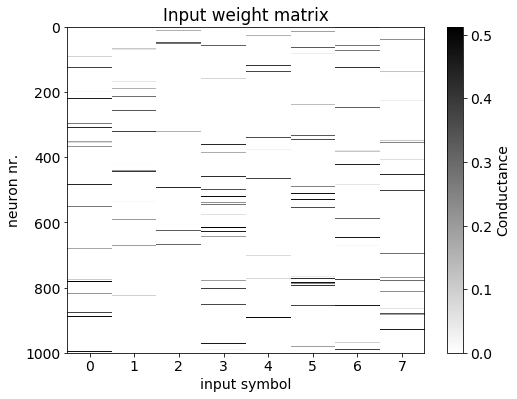

In [142]:
plt.imshow(net.w["input"], aspect="auto", cmap="gray_r")
plt.title("Input weight matrix")
plt.ylabel("neuron nr.")
plt.xlabel("input symbol")
c = plt.colorbar()
c.set_label("Conductance")
plt.show()

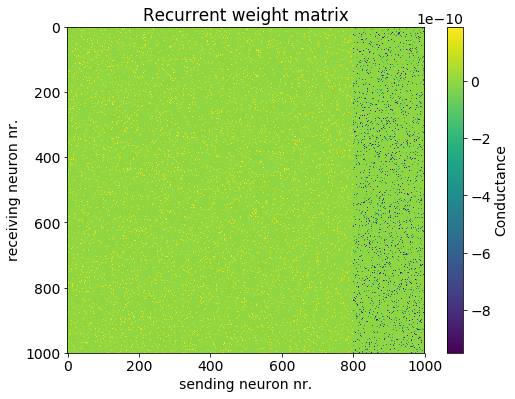

In [143]:
plt.imshow(net.w["recurrent"], aspect="auto")
plt.title("Recurrent weight matrix")
plt.ylabel("receiving neuron nr.")
plt.xlabel("sending neuron nr.")
c2 = plt.colorbar()
c2.set_label("Conductance")
plt.show()

In [144]:
# Configure recording matrices

net.config_recording(n_neurons=net.neurons["N"], t=params.sim["T"], dataset=ds2, downsample=None)

# Create step current for input
step = params.step_current(t=net.recording["t_orig"], on=0.3, off=0.35, amp=4.4e-9)

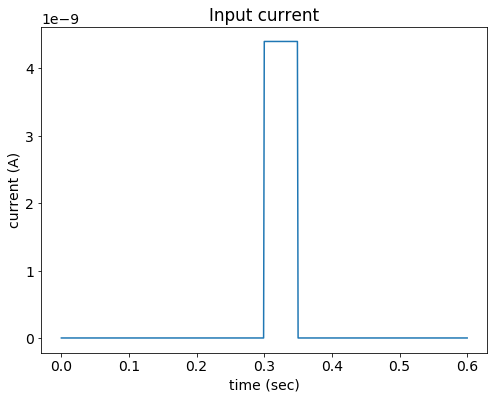

In [145]:
plt.plot(params.sim["T"], step)
plt.title("Input current")
plt.xlabel("time (sec)")
plt.ylabel("current (A)")
plt.show()

### Stimulate and record network responses

In [146]:
# Train the network
net.train(dataset=ds2, current=step)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11


### Plot responses

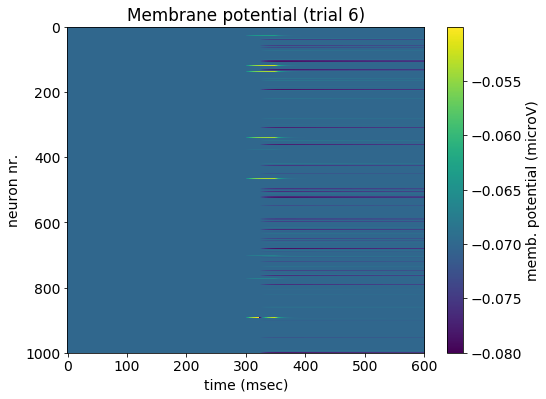

In [147]:
trial = 5
plt.imshow(net.recording["V"][trial,:,:], aspect="auto") # trial nr 1
plt.title("Membrane potential " + "(trial " + str(trial+1) + ")")
plt.xlabel("time (msec)")
plt.ylabel("neuron nr.")
c = plt.colorbar()
c.set_label("memb. potential (microV)")

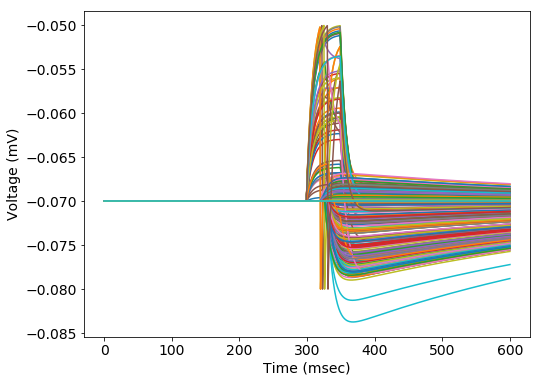

In [148]:
plt.plot(net.recording["V"][0,: , :].T)
plt.xlabel("Time (msec)")
plt.ylabel("Voltage (mV)")
plt.show()


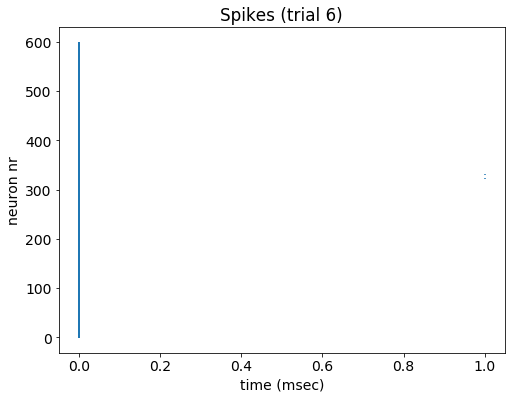

In [152]:
plt.eventplot(positions=net.recording["spikes"][0, :, :].T)
plt.title("Spikes " + "(trial " + str(trial+1) + ")")
plt.xlabel("time (msec)")
plt.ylabel("neuron nr")
plt.show()